In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import multivariate_normal
from scipy.integrate import quad
from scipy import integrate
from math import pi, sqrt, exp
import matplotlib.pyplot as plt
import random

In [ ]:
# Defining the dataset

def generate_data(n=10000, seed = 0, beta1=1.05, alpha1=0.4, alpha2=0.3):
    np.random.seed(seed)
    age = np.random.normal(65, 5, n)
    sodium = age / 18 + np.random.normal(size=n)
    bloodpressure = beta1 * sodium + 2 * age + np.random.normal(size=n)
    proteinuria = alpha1 * sodium + alpha2 * bloodpressure + np.random.normal(size=n)
    return pd.DataFrame({'bloodpressure': bloodpressure, 'sodium': sodium,
                         'age': age, 'proteinuria': proteinuria})

data = generate_data(n=10000, seed = 0, beta1=1.05, alpha1=0.4, alpha2=0.3)
data

,bloodpressure,sodium,age,proteinuria
0,152.064528,3.899009,73.820262,47.550194
1,137.034579,2.889035,67.000786,42.570771
2,146.502908,5.616583,69.893690,46.701630
3,157.482588,4.424230,76.204466,49.149768
4,150.321303,3.952067,74.337790,47.330976
...,...,...,...,...
9995,115.055490,3.380195,55.953592,34.411525
9996,133.527710,3.513880,65.211794,43.474980
9997,137.539744,3.697427,67.584361,44.430752
9998,133.317824,2.543035,64.835397,41.212528


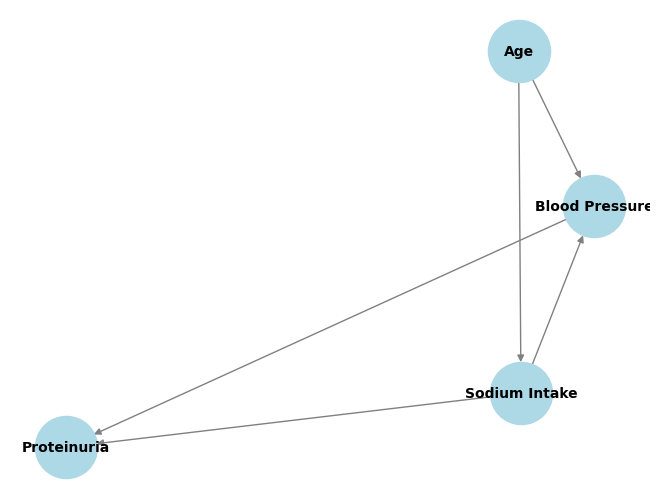

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a DAG
G = nx.DiGraph()

# Add nodes
G.add_node("Sodium Intake")
G.add_node("Blood Pressure")
G.add_node("Age")
G.add_node("Proteinuria")

# Add edges
G.add_edge("Sodium Intake", "Blood Pressure")
G.add_edge("Age", "Blood Pressure")
G.add_edge("Age", "Sodium Intake")
G.add_edge("Blood Pressure", "Proteinuria")
G.add_edge("Sodium Intake", "Proteinuria")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', edge_color='gray')

# Show the plot
plt.show()


In [ ]:
X = data[['sodium', 'age']]
y = data['bloodpressure']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Training the model on the training set
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting blood pressure for the testing set
y_pred_test = model.predict(X_test)

# Calculating accuracy metrics for the testing set
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print('The mean square error is', mse_test)
print('The accuracy of the model is',r2_test)
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
ate_sodium = coefficients.loc['sodium', 'Coefficient']
print(coefficients)

The mean square error is 1.042865472546016
The accuracy of the model is 0.9904440763734488
        Coefficient
sodium     1.062487
age        1.998454


In [ ]:
# Estimating the ATE of sodium intake on blood pressure

X1 = pd.DataFrame.copy(X)
X1['sodium'] = 1
X0 = pd.DataFrame.copy(X)
X0['sodium'] = 0
ate_est = np.mean(model.predict(X1) - model.predict(X0))
print('ATE estimate:', ate_est)
print('The true value of the ATE of sodium intake on blood pressure is', 1.05)

ATE estimate: 1.062486946135834
The true value of the ATE of sodium intake on blood pressure is 1.05


Now, we use the following formula to calculate the FATE of sodium intake (S) on blood pressure (B):

$$\mathrm{FATE}_l^h(B; S):= \int_{-\infty}^{\infty}\mathbb{E}(B(s))\left(f_h(s) - f_l(s)\right)
\,\mathrm{d} s,$$
where
$$f_l(s) =\frac{\mu_{l}(s)}{\lVert low\rVert},\qquad f_h(s) =\frac{\mu_{h}(s)}{\lVert high\rVert},\quad \lVert low\rVert = \int \mu_l(s)\,\mathrm{d} s,\;\; \lVert high\rVert = \int \mu_h(s)\,\mathrm{d} s$$
Also, $\mu_l(s)$ and $\mu_h(s)$ are defined as it is shown in the following block of the code (here $l$ and $h$ stand for $low$ and $high$, respectively).

In [ ]:
# Estimating the FATE of sodium intake on blood pressure

import scipy.integrate as spi

def expected_yt(t):
  X1 = pd.DataFrame.copy(X)
  X1['sodium'] = t
  return np.mean(model.predict(X1))

min_soidum = data['sodium'].min()
max_sodium = data['sodium'].max()
point_0 = min_soidum
point_1 = (max_sodium + min_soidum)/2
point_2 = max_sodium

# Defining mu_l(t) and mu_h(t)

def low(t):
  if point_0 <= t <= point_1:
    return -(1/(point_1 - point_0))*(t - point_1)
  else:
    return 0

def high(t):
  if point_1 <= t <= point_2:
    return (1/(point_2 - point_1))*(t - point_1)
  else:
    return 0

# Calculating ||low|| and ||high||

norm_low, _ = spi.quad(low, point_0, point_2)
norm_high, _ = spi.quad(high, point_0, point_2)

# Calculating the FATE of sodium intake on blood pressure.

def integrand_low(t):
  return expected_yt(t) * low(t)

def integrand_high(t):
  return expected_yt(t) * high(t)

expected_low, error_low = spi.quad(integrand_low, point_0, point_2)
expected_low = expected_low/norm_low

expected_high, error_high = spi.quad(integrand_high, point_0, point_2)
expected_high = expected_high/norm_high

FATE = expected_high - expected_low
print('FATE = ', FATE)
print('True value = ', (2*(point_2 - point_0)/3)*1.05)
print('To see why the true value is this, see the paper.')

FATE =  5.916504671062739
True value =  5.8469705695769045
To see why the true value is this, see the paper.


$$\mathrm{NFATE}_l^h(B;S):= \frac{\mathrm{FATE}_l^h(B; S)}{\mathbb{E}(S-S')} = \frac{\int_{-\infty}^{\infty}\mathbb{E}(B(s))\left(f_h(s) - f_l(s)\right)
	\,\mathrm{d} s}{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} (s-s')f_h(s)f_l(s')\, \mathrm{d}s'  \mathrm{d} s},$$
  where in $\mathbb{E}(S-S')$, $S$ and $S'$ come from the distributions based on $f_h$ and $f_l$, respectively.

In [ ]:
# Calculating E(S - S') as described above.

from scipy.integrate import dblquad

def integrand(x, y):
    return (y-x)*(low(x)/norm_low)*(high(y)/norm_high)

x_lower = point_0
x_upper = point_2
y_lower = lambda x: point_0
y_upper = lambda x: point_2

denominator, _ = dblquad(integrand, x_lower, x_upper, y_lower, y_upper)

# Calculating the NFATE_l^h of sodium intake on blood pressure

print("NFATE = ", FATE/denominator)
print("True value = ", 1.05)

NFATE =  1.062486946135836
True value =  1.05


$$\mathrm{GFATE}_l^h(B; S) = \int\mathbb{E}(B(s))(f_{\zeta_{S,h}}(s)-f_{\zeta_{S,l}}(s))\,\mathrm{d} s,$$
where
$$ f_{\zeta_{S,h}}(s) = \frac{f_S(s)\mu_h(s)}{\lVert generalized\_high\rVert}, \quad  f_{\zeta_{S,l}}(s) = \frac{f_S(s)\mu_l(s)}{\lVert generalized\_low\rVert},$$
where $f_S$ is the probability density function of sodium intake, and we have that  
$$\lVert generalized\_high\rVert = \int f_S(s)\mu_h(s)\,\mathrm{d} s,\quad  \lVert generalized\_low\rVert = \int f_S(s)\mu_l(s)\,\mathrm{d} s$$

In [ ]:
# Finding the distribution of sidun intake

mu_sodium = data['sodium'].mean()
std_sodium = sqrt(data['sodium'].var())

def density_sodium(t):
  return (1/((sqrt(2*pi))*std_sodium))*exp(-((t-mu_sodium)**2)/(2*(std_sodium**2)))

# Calculating ||generalized_low|| and ||generalized_high||

def generalized_low(t):
  return low(t) * density_sodium(t)
def generalized_high(t):
  return high(t) * density_sodium(t)

norm_generalized_low, _ = spi.quad(generalized_low, point_0, point_2)
norm_generalized_high, _ = spi.quad(generalized_high, point_0, point_2)

# Calculating the GFATE_l^h of sodium intake on blood pressure

def generalized_integrand_low(t):
  return expected_yt(t) * low(t) * density_sodium(t)/norm_generalized_low

def generalized_integrand_high(t):
  return expected_yt(t) * high(t) * density_sodium(t)/norm_generalized_high

generalized_expected_low, _ = spi.quad(generalized_integrand_low, point_0, point_2)
generalized_expected_high, _ = spi.quad(generalized_integrand_high, point_0, point_2)

GFATE = generalized_expected_high - generalized_expected_low
print('GFATE = ', GFATE)
#print('True value = ', (2*(point_2 - point_0)/3)*1.05)
#print('To see why the true value is this, see the paper.')

GFATE =  2.770509326847076


$$\mathrm{NGFATE}_l^h(B; S):= \frac{\mathrm{GFATE}_l^h(B; S )}{\mathbb{E}(S-S')} = \frac{\int_{-\infty}^{\infty}\mathbb{E}(B(s))\left(f_{\zeta_{S,h}}(s) - f_{\zeta_{S,l}}(s)\right)
	\,\mathrm{d} s}{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} (s-s')f_{\zeta_{S,h}}(s)f_{\zeta_{S,l}}(s')\, \mathrm{d}s'  \mathrm{d} s},$$
  where in $\mathbb{E}(S-S')$, $S$ and $S'$ come from the distributions based on $f_{\zeta_{S,h}}$ and $f_{\zeta_{S,l}}$, respectively.

In [ ]:
# Calculating the denominator of the above formula

def generalized_integrand(tp, t):
    return (t-tp)*(low(tp)*density_sodium(tp))*(high(t)*density_sodium(t))/(norm_generalized_high * norm_generalized_low)

tp_lower = point_0
tp_upper = point_2
t_lower = lambda tp: point_0
t_upper = lambda tp: point_2

generalized_denominator, _ = dblquad(generalized_integrand, tp_lower, tp_upper, t_lower, t_upper)

# Calculating the NGFATE_l^h of sodium intake on blood pressure

print("NGFATE = ", GFATE/generalized_denominator)
print("True value = ", 1.05)

NGFATE =  1.0624869461358228
True value =  1.05
